             Open   High    Low  Close  Volume
Date                                          
2020-06-02  85.00  85.50  85.00  85.30   11947
2020-06-03  86.15  86.90  86.10  86.80   18117
2020-06-04  87.50  87.75  87.15  87.60   15036
2020-06-05  87.70  88.35  87.70  88.35    9916
2020-06-08  88.90  89.80  88.80  89.50   15549


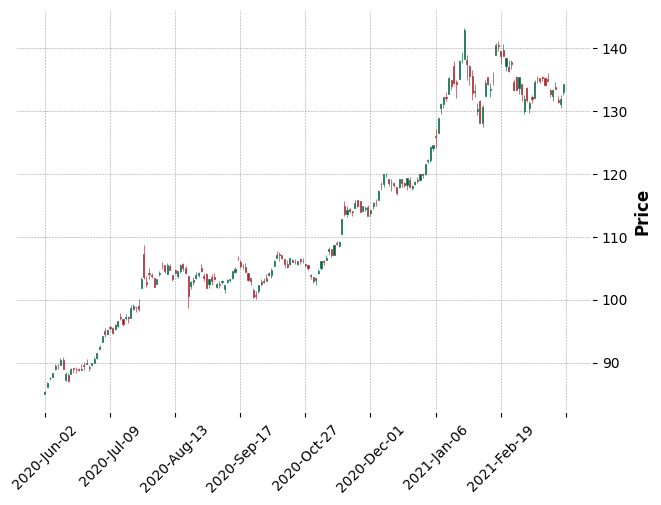

In [52]:
import pandas as pd
import mplfinance as mpf
# 讀取股票檔案，最新100筆資料
SData = pd.read_csv('2330.csv',index_col='Date').iloc[-200:,:]
# 更改時間格式
SData.index = pd.DatetimeIndex(SData.index)
print(SData.head())
mpf.plot(SData, type='candle', style ='charles')

In [53]:
def BBands(data, period=20, std_num=2):
    
    # 複製一份資料，避免修改原始資料
    res = data.copy(deep=True)

    # 計算中線，也就是二十日 MA
    res['bbands_middle'] = data['Close'].rolling(period).mean()
    
    # 計算標準差
    std = data['Close'].rolling(period).std(ddof=0) 
    
    # 計算上下軌
    res['bbands_upper'] = res['bbands_middle'] + std * std_num 
    res['bbands_lower'] = res['bbands_middle'] - std * std_num

    return res

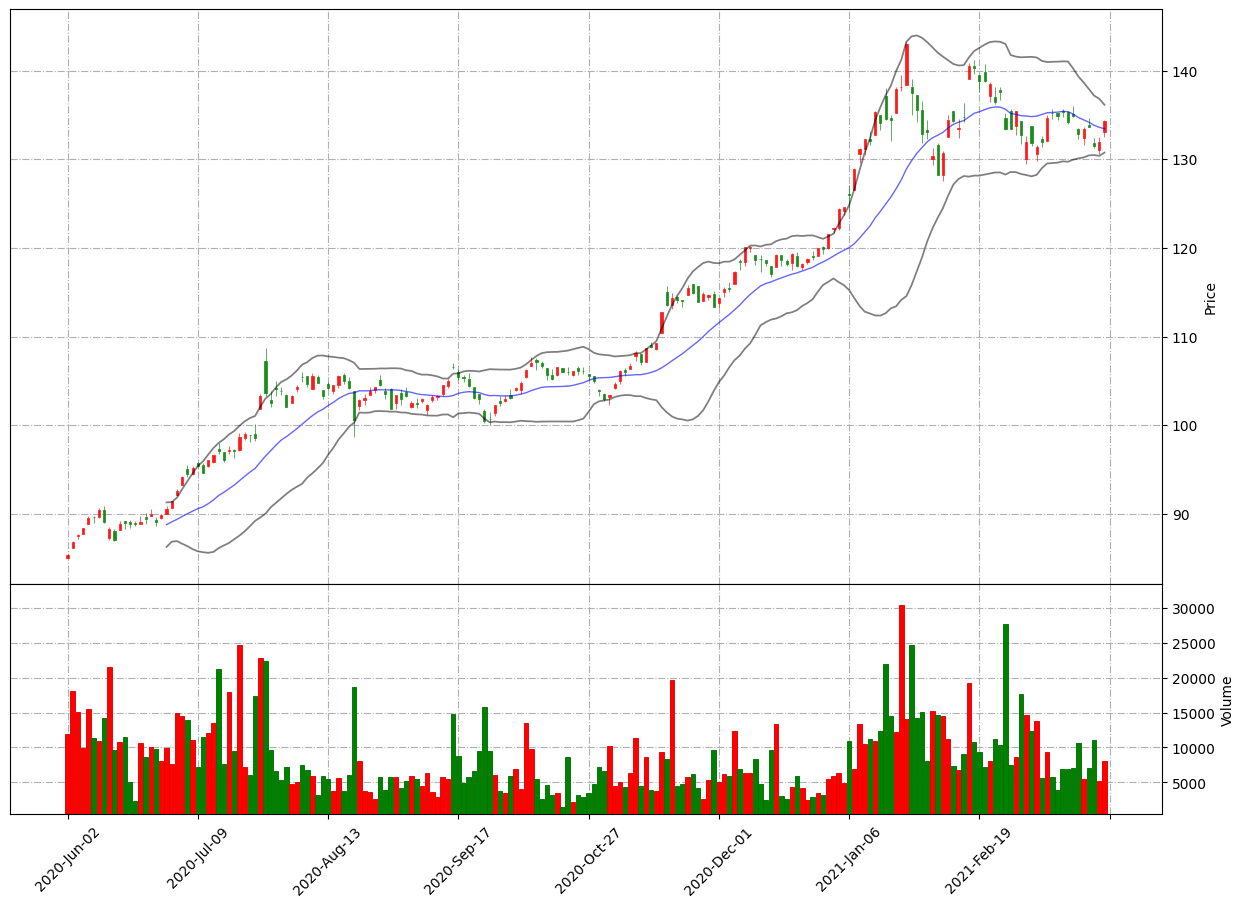

In [68]:
bbands_data = BBands(SData)
#print(bbands_data)

addplots = [
            mpf.make_addplot(bbands_data['bbands_middle'], panel=0, color='b', alpha=0.6
                             , width=1, secondary_y=False),
            mpf.make_addplot(bbands_data['bbands_upper'], color = 'black', alpha=0.5),
            mpf.make_addplot(bbands_data['bbands_lower'], color = 'black', alpha=0.5)
           ]
# 設置k線圖顏色
my_color = mpf.make_marketcolors(up='red',      # 上漲顏色
                                 down='green',  # 下跌顏色
                                 edge='i',      # 隱藏 K 線邊緣
                                 volume='in',   # 成交量用同樣的顏色
                                 inherit=True)  # 繼承其他參數
# 設置圖型呈現
my_style = mpf.make_mpf_style(gridaxis='both',          # 設置網格
                              gridstyle='-.',           # 設定網格花樣
                              y_on_right=True,          # y 座標放右邊
                              marketcolors=my_color)    # 設定k線圖顏色

kwargs = dict(type = 'candle', 
              figscale = 2, # 設定圖型大小
              style = my_style)

_panel = 2
mpf.plot(SData,
         **kwargs,
         num_panels=_panel,          # 設定總層數
         main_panel=0,               # 設定 K 線圖層數
         volume=True,              # 設定是否繪製成交量 
         volume_panel=_panel - 1,    # 設定成交量層數             
         show_nontrading=False,      # 忽略非交易日
         tight_layout=False,          # 設定布局方式
         addplot = addplots)

In [2]:
def bbands_ema_rule(_ticker, buy_point_name='buy_point', 
        bb_period=20, bb_stdnum=2, ma_period=5):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 檢查使否存在要用的指標
    try:
        if not {'bbands_middle', 'bbands_upper', 'bbands_lower'}.issubset(res.columns):
            res = BBands(res, bb_period, bb_stdnum)
        if not {'EMA_' + str(ma_period)}.issubset(res.columns):
            res = EMA(res, ma_period)
    except Exception as e:
        print(e)
        return False

    # 新增一個空行，預設值為零
    res[buy_point_name] = 0

    # 取得 index 值，方便計算使用
    t = res.index

    # 判斷前幾日始否跌破下軌了
    is_lower = False
    is_upper = False

    for i in range(1, len(res)):

        # 計算是否符合做多首要條件
        if res.loc[t[i], 'Close'] < res.loc[t[i], 'bbands_lower']:
            is_lower = True
        elif res.loc[t[i], 'Close'] > res.loc[t[i], 'bbands_middle']:
            is_lower = False

        # 計算是否符合做空首要條件
        if res.loc[t[i], 'Close'] > res.loc[t[i], 'bbands_upper']:
            is_upper = True
        elif res.loc[t[i], 'Close'] < res.loc[t[i], 'bbands_middle']:
            is_upper = False
        
        # 計算做多點
        if is_lower and res.loc[t[i], 'Close'] > res.loc[t[i], 'EMA_' + str(ma_period)] \
                or res.loc[t[i], 'bbands_upper'] > res.loc[t[i - 1], 'bbands_upper'] \
                and res.loc[t[i], 'bbands_middle'] > res.loc[t[i - 1], 'bbands_middle'] \
                and res.loc[t[i], 'bbands_lower'] > res.loc[t[i - 1], 'bbands_lower']:
            
            res.loc[t[i], 'buy_point'] = 1
        
        # 計算做空點
        elif is_upper and res.loc[t[i], 'Close'] < res.loc[t[i], 'EMA_' + str(ma_period)] \
                or res.loc[t[i], 'bbands_upper'] < res.loc[t[i - 1], 'bbands_upper'] \
                and res.loc[t[i], 'bbands_lower'] > res.loc[t[i - 1], 'bbands_lower']:
            
            res.loc[t[i], 'buy_point'] = -1

    return res